# Evaluation History - Segmentation Masks

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import datetime

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.evaluation import show_metrics

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['image.cmap'] = 'viridis'

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [3]:
import tensorflow as tf

# RANDOM_SEED = 250398
# tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.2
Num GPUs Available:  1


## Setup

In [4]:
%%time

ROOT_DIR = '../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False

class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path,
    ROOT_DIR,
    split=(0.8, 0.15, 0.05),
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization,
    segmentation=True)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq

model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../tmp\logs\20210429-151939
Wall time: 0 ns


In [5]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_type = '3d_cnn'
model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
#     'l2_beta': 0.0005,
    'l2_beta': None,
#     'dropout': 0.05,
    'dropout': 0.10,
    'output_bias': initial_bias,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    'batch_norm': True,
    'is_complex': False, # a complex layer from the paper, max batch_size is 3
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00010,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 150,
    'patience': 75,
    'tensorboard_update_freq': 'epoch',
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
#     'augmentations': False,
    'augmentations': {
        'invert': (0.5, None),
        'rotate': (0.2, 5), # probability, degrees
        'zoom': (0., 0.),
        'shear': (0.2, 0.5), # probability, degrees
        'blur': (0.2, 0.85),
        'noise': (0.2, 0.00020)
    },
    'batch_size': 8,
#     'model_checkpoint_callback': False,
}

## Model

In [6]:
model = create_model(model_type, model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 104, 128, 104, 32) 896       
_________________________________________________________________
batch_normalization (BatchNo (None, 104, 128, 104, 32) 128       
_________________________________________________________________
activation (Activation)      (None, 104, 128, 104, 32) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 52, 64, 52, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 52, 64, 52, 64)    55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 52, 64, 52, 64)    256       
_________________________________________________________________
activation_1 (Activation)    (None, 52, 64, 52, 64)    0

In [7]:
load_checkpoint(model, DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL, '20210308-175324', 'cp-0058.ckpt')

loading checkpoint from ../../tmp\bckp-checkpoints\20210308-175324\cp-0058.ckpt...


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.8333333333333334
recall: 0.8064516129032258
f1-score: 0.819672131147541
support: 62


CN
precision: 0.7
recall: 0.7368421052631579
f1-score: 0.717948717948718
support: 38


micro avg
precision: 0.78
recall: 0.78
f1-score: 0.78
support: 100


macro avg
precision: 0.7666666666666666
recall: 0.7716468590831917
f1-score: 0.7688104245481295
support: 100


weighted avg
precision: 0.7826666666666666
recall: 0.78
f1-score: 0.7810172341319883
support: 100


samples avg
precision: 0.78
recall: 0.78
f1-score: 0.78
support: 100


F1
micro: 0.78
macro: 0.7688104245481295


accuracy_score: 0.78
sensitivity_score: 0.8064516129032258
specificity_score: 0.7368421052631579


Wall time: 56.2 s


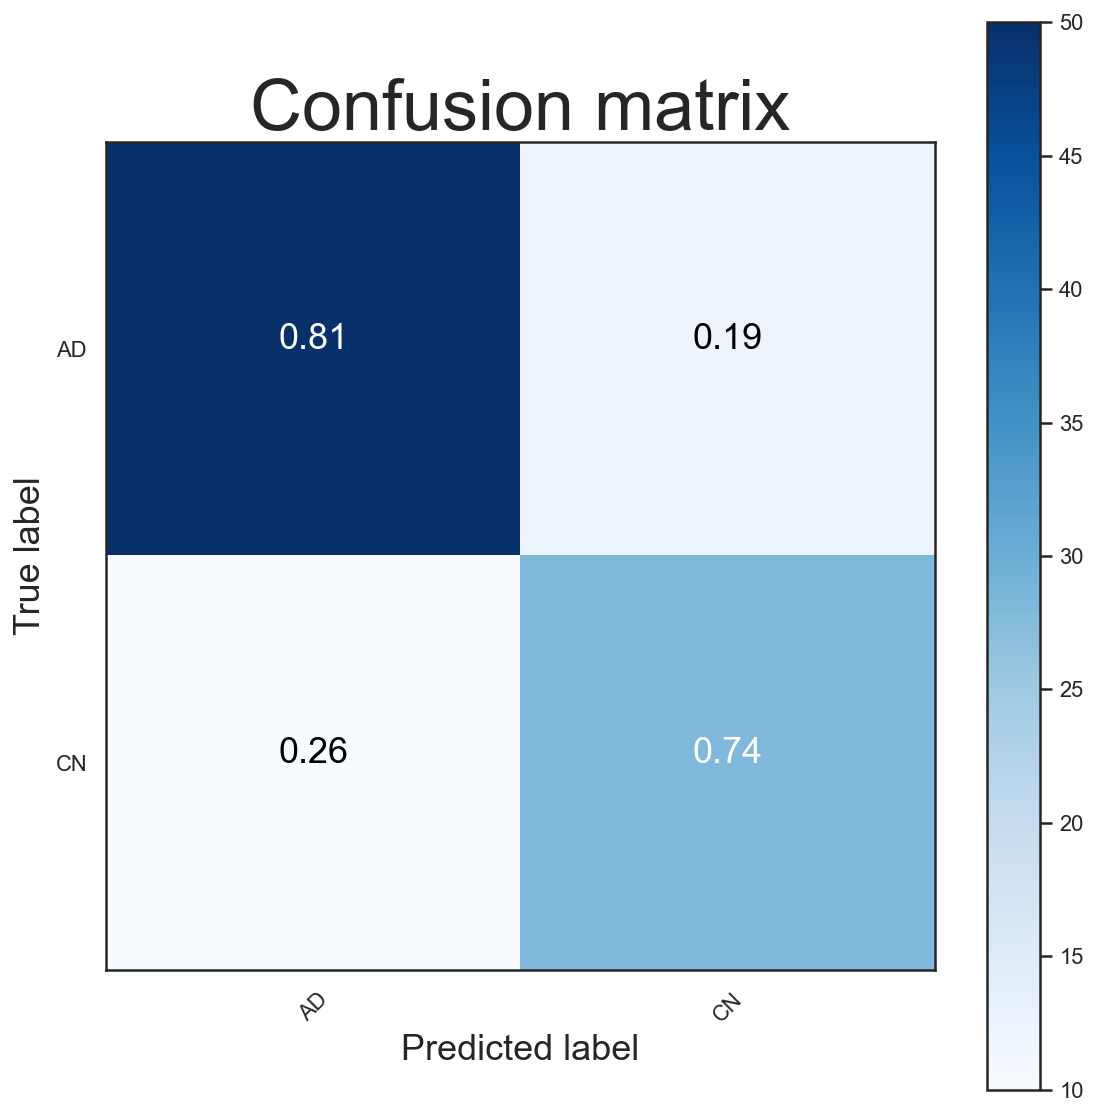

In [8]:
%%time

# just to test of it is ok to clear the session after loading the weigths
tf.keras.backend.clear_session()

show_metrics(model, test_seq, class_names)

## Evaluation

In [51]:
import time

from src.evaluation.segmentation_masks import SegmentationMasksSaver, SegmentationMasksEvaluator, \
    get_segmentation_masks_factory, plot_segmentation, dim_selector_factory

import matplotlib.colors as colors
import matplotlib.cm as cm

def hmap_imshow_factory(do_norm=True):
    def hmap_imshow(ax, image_x, alpha):
        vmin = None if do_norm else 0
        vmax = None if do_norm else 1
        ax.imshow(image_x, alpha=alpha, cmap='jet')
        norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
        plt.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), fraction=0.046, pad=0.04)
    return hmap_imshow

In [83]:
# notebook_key = 'captum--guided-backprop'
notebook_key = 'captum--guided-grad-cam'
# notebook_key = 'captum--grad-cam'
# notebook_key = 'risei--3d-cnn--m+2048--b1+0--b2+1--s+8--p1+0.25'
# notebook_key = 'risei--3d-cnn--m+2048--b1+0--b2+1--s+16--p1+0.25'

BATCH_SIZE = 12

In [84]:
%%time

get_segmentation_masks = get_segmentation_masks_factory(model, test_seq, max_category=20, fp_max=0, fn_max=0, 
                                                        batch_size=BATCH_SIZE)

def hisotry_fname_factory():
    fkey = notebook_key
    fname_ins = f'{fkey}-insertion-TP-TN'
    fname_del = f'{fkey}-deletion-TP-TN'
    return ('../../tmp/risei-history', fkey, fname_ins, fname_del)

evaluator = SegmentationMasksEvaluator(
    get_segmentation_masks,
    hisotry_fname_factory,
)

saver = SegmentationMasksSaver(ROOT_DIR)
row = evaluator.to_row()
print('saving row...')
print(row)
saver.add_row(row)

tp: 20, tn: 20, fp: 0, fn: 0
(40, 104, 128, 104, 1)
saving row...
{'notebook_key': 'captum--guided-grad-cam', 'y_true__mean': 0.5, 'y_pred__mean': 0.48861381560564043, 'arr_heat_sum__0__mean': 8952.845435926194, 'arr_heat_sum__1__mean': 2008.445709501872, 'arr_heat_sum__2__mean': 1411.6281319487045, 'arr_heat_sum__3__mean': 190.7939250971901, 'arr_heat_sum__4__mean': 10.1627599029441, 'arr_heat_sum_norm__0__mean': 0.009552199386803658, 'arr_heat_sum_norm__1__mean': 0.007860929763486235, 'arr_heat_sum_norm__2__mean': 0.00842376612284059, 'arr_heat_sum_norm__3__mean': 0.009754527985773106, 'arr_heat_sum_norm__4__mean': 0.006561259958197277, 'arr_heat_sum_gain__0__mean': 1.0, 'arr_heat_sum_gain__1__mean': 0.6330826393903424, 'arr_heat_sum_gain__2__mean': 0.6298595801840259, 'arr_heat_sum_gain__3__mean': 0.7655241967104581, 'arr_heat_sum_gain__4__mean': 0.48775177594199076, 'arr_heat_sum_gain_other__mean': 0.6357566052363841, 'y_true__std': 0.5063696835418333, 'y_pred__std': 0.204025616502

In [75]:
evaluator.df.describe()

,y_true,y_pred,arr_heat_sum__0,arr_heat_sum__1,arr_heat_sum__2,arr_heat_sum__3,arr_heat_sum__4,arr_heat_sum_norm__0,arr_heat_sum_norm__1,arr_heat_sum_norm__2,arr_heat_sum_norm__3,arr_heat_sum_norm__4,arr_heat_sum_gain__0,arr_heat_sum_gain__1,arr_heat_sum_gain__2,arr_heat_sum_gain__3,arr_heat_sum_gain__4,arr_heat_sum_gain_other
count,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.0,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.50000,0.488614,42151.848967,12439.041002,7837.925800,1125.759610,98.477822,0.045209,0.047082,0.046575,0.067076,0.057461,1.0,1.041382,1.030030,1.484960,1.272884,1.051863
std,0.50637,0.204026,4955.727171,1813.186236,1311.232710,604.597916,25.898866,0.004982,0.005307,0.005592,0.010064,0.007633,0.0,0.021653,0.042303,0.158921,0.118742,0.028611
min,0.00000,0.110623,29775.570062,8174.351509,5254.553275,304.487193,48.611235,0.031716,0.032870,0.033232,0.044889,0.033726,1.0,1.004820,0.955705,1.210053,1.026398,1.002378
25%,0.00000,0.331808,37929.305353,11064.122062,7119.953381,618.595380,83.094676,0.042453,0.044281,0.044151,0.060883,0.053557,1.0,1.025443,1.007236,1.376771,1.217379,1.035227
50%,0.50000,0.507475,42377.421400,12729.002068,7695.999968,1058.780342,100.655431,0.046195,0.047288,0.045904,0.065906,0.056245,1.0,1.037753,1.025972,1.453996,1.255912,1.048978
75%,1.00000,0.651682,45818.472520,13717.675330,8527.317004,1460.943114,118.329773,0.049069,0.050998,0.049916,0.074163,0.062287,1.0,1.054593,1.050083,1.642694,1.329147,1.066996
max,1.00000,0.828123,50286.813017,17425.488245,12178.190210,3292.941728,157.172445,0.052259,0.056299,0.058374,0.088961,0.077640,1.0,1.091895,1.162392,1.741258,1.665143,1.136935


In [76]:
evaluator.df[evaluator.df['arr_heat_sum_gain_other'] >= 1]

,y_true,y_pred,arr_heat_sum__0,arr_heat_sum__1,arr_heat_sum__2,arr_heat_sum__3,arr_heat_sum__4,arr_heat_sum_norm__0,arr_heat_sum_norm__1,arr_heat_sum_norm__2,arr_heat_sum_norm__3,arr_heat_sum_norm__4,arr_heat_sum_gain__0,arr_heat_sum_gain__1,arr_heat_sum_gain__2,arr_heat_sum_gain__3,arr_heat_sum_gain__4,arr_heat_sum_gain_other
0,0.0,0.612180,45326.525548,11081.936294,7140.606247,425.562916,48.611235,0.046009,0.048258,0.043971,0.066266,0.057939,1.0,1.048883,0.955705,1.440280,1.259297,1.017725
1,1.0,0.376239,49311.715069,11259.998745,7223.959527,586.171487,99.540609,0.048706,0.050984,0.050908,0.078808,0.054663,1.0,1.046771,1.045210,1.618025,1.122295,1.057967
2,0.0,0.648163,46773.472382,13345.114050,7037.925703,1745.171237,73.603767,0.049118,0.051040,0.049689,0.062303,0.068789,1.0,1.039116,1.011623,1.268429,1.400468,1.045863
3,0.0,0.752286,37947.666921,10637.088086,5830.168463,1475.659218,50.774918,0.039754,0.041517,0.040691,0.050181,0.051601,1.0,1.044360,1.023569,1.262284,1.298004,1.052919
4,1.0,0.197332,46810.653111,14802.281921,10416.556878,868.351937,157.172445,0.052071,0.053751,0.052662,0.088961,0.062296,1.0,1.032256,1.011356,1.708462,1.196363,1.038189
5,0.0,0.729525,36432.470136,10161.257019,6614.910221,607.097201,50.036685,0.038878,0.039425,0.037268,0.054812,0.048066,1.0,1.014070,0.958600,1.409849,1.236332,1.002378
6,1.0,0.369078,37874.220647,12947.238579,8733.476539,1024.010838,121.329711,0.043219,0.044665,0.043595,0.065545,0.052821,1.0,1.033453,1.008701,1.516567,1.222159,1.039402
7,0.0,0.570897,29775.570062,8174.351509,5642.056664,1231.707627,49.277124,0.031716,0.032870,0.033488,0.044889,0.047657,1.0,1.036391,1.055862,1.415329,1.502598,1.068166
8,0.0,0.635376,39527.658790,10905.104329,7581.126938,1798.296457,108.594559,0.042471,0.043625,0.044579,0.056732,0.053840,1.0,1.027170,1.049624,1.335785,1.267679,1.058214
9,0.0,0.632787,39215.101046,10821.212618,7620.439225,2002.922170,107.160032,0.042400,0.043294,0.044211,0.056775,0.054424,1.0,1.021095,1.042713,1.339049,1.283581,1.054735


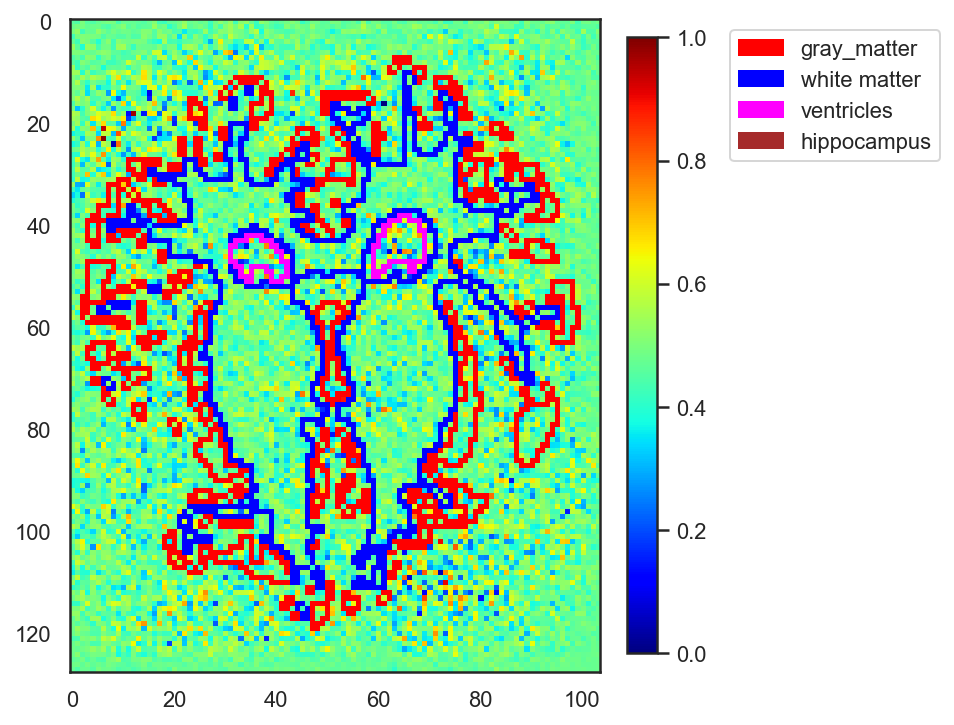

In [81]:
seg_mask, seg_label, image_x, image_y, heatmap, image_y_pred = evaluator.images[20]

fig = plot_segmentation(seg_mask, seg_label, image_x, image_y, heatmap, 
                        dim_selector_factory(z=56), alpha=0, edges=True,
                        show_image=True, show_heatmap=True, hmap_imshow=hmap_imshow_factory(False))

1.0489777011563841


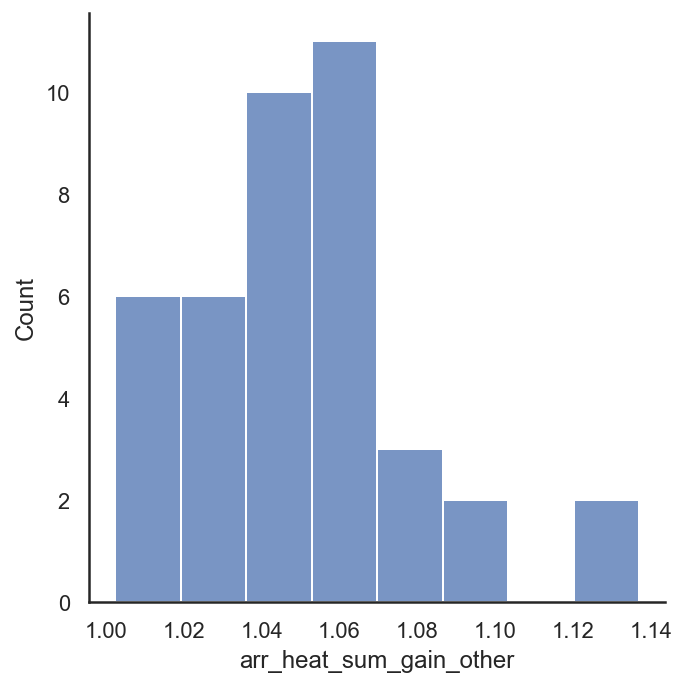

In [82]:
print(evaluator.df['arr_heat_sum_gain_other'].median())
sns.displot(evaluator.df['arr_heat_sum_gain_other'])

In [ ]:
# TODO: https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient